### Two Body Simulation

A worksheet to simulate two spiraling black holes, using Post-Minkowski corrections to accounts for effects of relativity.

In [1]:
######
### This is the inital cell which prepares all of the necessary 
### packages and functions for use.
######

using Pkg
using DifferentialEquations
using Plots
using LSODA

#This is a homemade package containing the differential equations used to calculate the Hamiltonian numerically.
Pkg.activate("HamiltonianFunctions")
using HamiltonianFunctions

@userplot TwoBodyPlot
@recipe function f(tb::TwoBodyPlot)
    m, x, y, xarray, yarray, negx, posx, negy, posy = tb.args
    n = 100
    xlims --> (negx, posx)
    ylims --> (negy, posy)
    append!(xarray, x)
    append!(yarray, y)
    if size(xarray)[1] > n
        deleteat!(xarray, 1)
        deleteat!(yarray, 1)
    end
    linewidth --> range(0, m * 5, length = n)
    #seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    xarray, yarray
end

function differentiate(q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, tspan, c0, relativity)
    @time begin
        h01 = [0]
        q0 = collect(Base.Iterators.flatten([q01, q02]))
        p0 = collect(Base.Iterators.flatten([p01, p02]))
        u0 = collect(Base.Iterators.flatten([q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, h01]));
        
        if relativity
            prob = ODEProblem(HamiltonianFunctions.fiveBodyPM, u0, tspan, c0)
            #prob = HamiltonianProblem(HamiltonianFunctions.pmnbody, q0, p0, tspan, c0)
        else
            prob = ODEProblem(HamiltonianFunctions.Hamiltonian, u0, tspan, c0)
            #prob = HamiltonianProblem(HamiltonianFunctions.HNewtonian, q0, p0, tspan, c0)
        end
        
        #sol = solve(prob, KahanLi8(), dt=0.1, reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        #sol = solve(prob, RK4(), adaptive = true, reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        #sol = solve(prob, Rosenbrock23(), reltol = 1.0e-2, abstol = 1.0e-2, saveat = 100);
        #sol = solve(prob, Rodas5(), reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        sol = solve(prob, lsoda(), reltol = 1.0e-9, abstol = 1.0e-9, saveat = 100);
        #sol = solve(prob, Tsit5(), reltol = 1.0e-8, abstol = 1.0e-8, saveat = 1000);
        #sol = solve(prob, ImplicitEuler(), reltol = 1.0e-5, abstol = 1.0e-5, saveat = 100);
        #sol = solve(prob, ERKN4(), reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);
        
        #sol = solve(prob, SymplecticEuler(), reltol = 1.0e-9, abstol = 1.0e-9, saveat = 100, dt = 0.5); 
        ##Use this last one doing the HamiltonianProblem rather than just an ODEproblem
    end
    return sol, time
end

 Activating environment at `~/Research/Post-Minkowski/notebooks/HamiltonianFunctions/Project.toml`


differentiate (generic function with 1 method)

In [8]:
######
### This cell is for setting the parameters of the code. 
### These parameters are manually changed by the user as desired.
######

CSI = 3.00e8;
GSI = 6.647e-11;
MSUN = 1.989e30;

m1 = 1.0; # Mass of the first body in solar masses
m2 = 0.000954588; # Mass of the second body
m3 = 0.0002857;
m4 = 0.00004365;
m5 = 0.00005149;

D = 10301300.0; # Initial separation of the first two bodies, in kilometers
ecc = 0.00000000000000; # eccentricity of the orbits
G = 1.0 / (16*pi); # Gravitational constant
C = 1.000000000000; #Speed of light
relativity = true; # A boolean value; if true, the code will apply Post-Minkowski relativistic corrections.
tspan = (0.0, 36050.0 * 10000); # The amount of time for which the simulation runs

M = MSUN
L = (GSI / G) * M * (C / CSI)^2
T = L * (C / CSI)

pUnits = M * L / T
KEUnits = pUnits * L / T;

In [11]:
######
### This cell is where the code does most of its calculations. 
### If desired, a different ODE solver can also be chosen in this cell; 
### all that aren't currently being used are commented out. It will
### print out the changes in kinetic energy throughout the simulation in joules,
### and after each of those the ending kinetic energy divided by the initial,
### and then the distance between the bodies at the end of the simulation.
######

#Calculates factors based on eccentricity

if !(0 <= ecc <= 1)
    ecc = 0.0
end
qfac = 1.0 - ecc;
pfac = sqrt((1.0 + ecc)/(1.0 - ecc));

#Calculates inital position and momentum

totalM = m1 + m2
mu = m1 * m2 / (totalM)
if relativity
    #This is the Schwarzschild solution for calculating initial momentum. 
    #Keep in mind this will be imaginary if they get too close, 
    #and consider that in first order, the PM solution has repulsive force if they get too close.
    p_theta = mu * D * sqrt((G * totalM)/(D - (3.0 * G * totalM)))
else
    p_theta = sqrt(G * m1 * m2 * mu * D )
end

x2 = D / (1 + (m1 / m2));
x1 = x2 - D;
py2 = p_theta / D;
println("Initial momentum is ", py2)
println("Corrected momentum is ", py2)
println()
py1 = -py2;

#Set up initial arrays for ODE problem

c0 = [m1, m2, m3, m4, m5, G]
q01 = [x1 * qfac, 0.0, 0.0]
p01 = [0.0, py1 * pfac, 0.0]
q02 = [x2 * qfac, 0.0, 0.0]
p02 = [0.0, py2 * pfac, 0.0]
q03 = [-20183000.0, 0.0, 0.0]
p03 = [0.0, -m1 * m3 sqrt(20183000.0 * G / (m1 + m3)), 0.0]
q04 = [0.0, 40042300.0, 0.0]
p04 = [-m1 * m4 sqrt(40042300.0 * G / (m1 + m4)), 0.0, 0.0]
q05 = [0.0, -60615400.0, 0.0]
p05 = [m1 * m5 sqrt(60615400.0 * G / (m1 + m5)), 0.0, 0.0]
h01 = [0]
q0 = collect(Base.Iterators.flatten([q01, q02, q03, q04, q05]))
p0 = collect(Base.Iterators.flatten([p01, p02, p03, p04, p05]))
u0 = collect(Base.Iterators.flatten([q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, h01]));

pi1, pi2 = sqrt((p01[1]^2) + (p01[2]^2)), sqrt((p02[1]^2) + (p02[2]^2));
KEi1, KEi2 = pi1^2 / (2 * m1), pi2^2 / (2 * m2);
initialKE1, initialKE2 = KEi1 * KEUnits, KEi2 * KEUnits


#Solve the equation
sol = differentiate(q01, p01, q02, p02, q03, p03, q04, p04, q05, p05, tspan, c0, relativity)[1]
println()

xlist1 = sol[1,:]
ylist1 = sol[2,:]
zlist1 = sol[3,:]
xlist2 = sol[7,:]
ylist2 = sol[8,:]
zlist2 = sol[9,:]

xlist3 = sol[13,:]
ylist3 = sol[14,:]
zlist3 = sol[15,:]
xlist4 = sol[19,:]
ylist4 = sol[20,:]
zlist4 = sol[21,:]
xlist5 = sol[25,:]
ylist5 = sol[26,:]
zlist5 = sol[27,:]
#ss3 = sol[3,:]
#ss4 = sol[4,:];

###Above is for Hamiltonian Problem, set ss3 and ss4 as below for ODE problem
#ss3 = sol[5,:]
#ss4 = sol[6,:];

#momentum1 = sol[5,:]
#momentum2 = sol[6,:]
###Above is for Hamiltonian Problem, set momentum1 and momentem2 as below for ODE problem
momentumx1 = sol[4,:]
momentumy1 = sol[5,:]
momentumz1 = sol[6,:]
momentumx2 = sol[10,:]
momentumy2 = sol[11,:]
momentumz2 = sol[12,:]

#Create an array that's just the value of the Hamiltonian. Comment this out for HamiltonianProblem.
hamilArr = sol[31,:];
deleteat!(hamilArr, 1);


#Set an array that contains the distances between both bodies
xdis, ydis, zdis = xlist1 - xlist2, ylist1 - ylist2, zlist1 - zlist2
distArr = (xdis.^2 + ydis.^2 + zdis.^2).^0.5

len = size(sol[1,:])[1]

pf1, pf2 = sqrt((momentumx1[len]^2) + (momentumy1[len]^2) + (momentumz1[len]^2)), sqrt((momentumx2[len]^2) + (momentumy2[len]^2) + (momentumz2[len]^2));
KEf1, KEf2 = pf1^2 / (2 * m1), pf2^2 / (2 * m2);
finalKE1, finalKE2 = KEf1 * KEUnits, KEf2 * KEUnits 
dKE1, dKE2 = finalKE1 - initialKE1, finalKE2 - initialKE2
xf, yf, zf = xlist1[len] - xlist2[len], ylist1[len] - ylist2[len], zlist1[len] - zlist2[len]
Df = sqrt(xf^2 + yf^2 + zf^2)
println("Change in KE of body 1 ", dKE1)
println("Ending KE of body 1 as a fraction of initial KE of body 1 ", KEf1/KEi1)
println()
println("Change in KE of body 2 ", dKE2)
println("Ending KE of body 2 as a fraction of initial KE of body 2 ", KEf2/KEi2)
println()
println("Final distance between objects ", Df, " = ", Df * L, " meters.")

Initial momentum is 4.192886285485554e-8
Corrected momentum is 4.192886285485554e-8



LoadError: syntax: missing separator in array expression

In [10]:
######
### This cell creates plots that will be saved to the directory.
######

#Plot the Hamiltonian for error checking; this shouldn't change by much. Comment this out for HamiltonianProblem.

scatter(hamilArr)
savefig("hamiltonian.png")

#Plot the change in distance between the bodies over time

plot(distArr)
savefig("distance.png")

#Plot the orbits of the bodies

plot(xlist1, ylist1, aspect_ratio = :equal)
plot!(xlist2, ylist2, aspect_ratio = :equal)
plot!(xlist3, ylist3, aspect_ratio = :equal)
plot!(xlist4, ylist4, aspect_ratio = :equal)
plt = plot!(xlist5, ylist5, aspect_ratio = :equal)
savefig("orbits.png")

┌ Info: Saved animation to 
│   fn = /Users/zackarywindham/Research/Post-Minkowski/notebooks/tmp.gif
└ @ Plots /Users/zackarywindham/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/Users/zackarywindham/Research/Post-Minkowski/notebooks/tmp.gif")
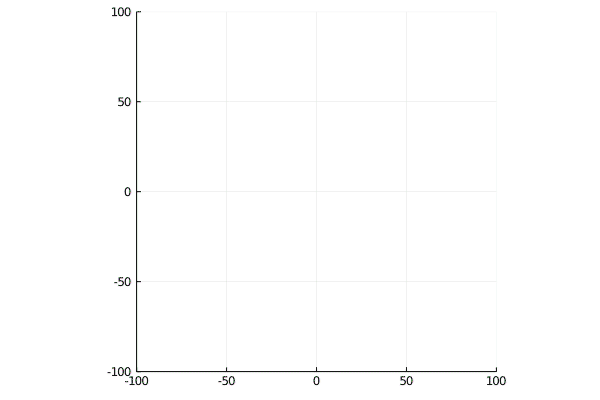

In [18]:
######
### If desired, this cell will animate the orbits of the bodies, 
### though the x and y bounds must be manually decided and inputted. 
######

xarr1, yarr1, xarr2, yarr2, xarr3, yarr3, xarr4, yarr4, xarr5, yarr5 = [], [], [], [], [], [], [], [], [], []
xneg, xpos, yneg, ypos = -100, 100, -100, 100

r = m1 / m2
m10 = r / (1 + r)
m20 = 1 - m10

anim = @gif for i = 1:size(xlist1)[1]
    twobodyplot(m10, xlist1[i], ylist1[i], xarr1, yarr1, xneg, xpos, yneg, ypos)
    twobodyplot!(m20, xlist2[i], ylist2[i], xarr2, yarr2, xneg, xpos, yneg, ypos)
    twobodyplot!(m10, xlist3[i], ylist3[i], xarr3, yarr3, xneg, xpos, yneg, ypos)
    twobodyplot!(m10, xlist4[i], ylist4[i], xarr4, yarr4, xneg, xpos, yneg, ypos)
    twobodyplot!(m10, xlist5[i], ylist5[i], xarr5, yarr5, xneg, xpos, yneg, ypos)
    end every 5